# Our Dataset

Collecting beer recipes for machine learning

## Outline
_Done_
* What we want to know about beer
* What beer data is out there
* What is beerXML
  * Load and print a beerXML file
  * Compare brewtoad and brewersfriend: presence/absense of tags
* How much did we get
  * Count recipes
* How did we represent it
  * Print a DataFrame  
* What does the beer recipe landscape look like
  * \# recipes/styles
  * what's cloned the most often?
  * most common malt, hop, yeast names
  * batch sizes
* Sneak preview: beer measurables (IBU, ABV, SRM)

In [1]:
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import re

from collections import defaultdict
from lxml import etree
from pprint import pprint
from wordcloud import WordCloud

from beerai.config import DATA_DIR, DOCS_IMAGES_DIR

### Brewtoad

In [2]:
recipes_folder = os.path.join(DATA_DIR, "raw/recipes/brewtoad/")
files = glob.glob(recipes_folder + "*snpa*")
files[0:50]

['/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-10gal-mash-version.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-clone-2011-01-01-version.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-32.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-31.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-3.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-clone-46.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-ish.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-clone-22.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/marmot-ipa-snpa-clone.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-clone.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-clone-31.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-20.xml',
 '/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpa-c

In [3]:
bt_snpa_example = os.path.join(DATA_DIR, "raw/recipes/brewtoad/snpaclone.xml")

In [4]:
with open(bt_snpa_example, "r") as f:
    beerxml = f.read()

In [5]:
pprint(beerxml)

('<?xml version="1.0" encoding="UTF-8"?>\n'
 '<RECIPES>\n'
 '  <RECIPE>\n'
 '    <NAME>SNPAclone</NAME>\n'
 '    <STYLE>\n'
 '      <STYLE_GUIDE>BJCP</STYLE_GUIDE>\n'
 '      <VERSION>1</VERSION>\n'
 '      <NAME>American Pale Ale</NAME>\n'
 '      <STYLE_LETTER>A</STYLE_LETTER>\n'
 '      <CATEGORY_NUMBER>10</CATEGORY_NUMBER>\n'
 '      <TYPE>Ale</TYPE>\n'
 '      <OG_MIN>1.045</OG_MIN>\n'
 '      <OG_MAX>1.06</OG_MAX>\n'
 '      <FG_MIN>1.01</FG_MIN>\n'
 '      <FG_MAX>1.015</FG_MAX>\n'
 '      <IBU_MIN>30.0</IBU_MIN>\n'
 '      <IBU_MAX>45.0</IBU_MAX>\n'
 '      <COLOR_MIN>5.0</COLOR_MIN>\n'
 '      <COLOR_MAX>14.0</COLOR_MAX>\n'
 '      <ABV_MIN>4.5</ABV_MIN>\n'
 '      <ABV_MAX>6.2</ABV_MAX>\n'
 '    </STYLE>\n'
 '    <FERMENTABLES>\n'
 '      <FERMENTABLE>\n'
 '        <NAME>2-Row (US)</NAME>\n'
 '        <ORIGIN></ORIGIN>\n'
 '        <TYPE>Base Malt</TYPE>\n'
 '        <YIELD>79.89635068019865</YIELD>\n'
 '        <AMOUNT>4.535923700000001</AMOUNT>\n'
 '        <DISPLAY_AMOUNT>

In [6]:
xml = etree.parse(bt_snpa_example)
for e in xml.iter():
    print(xml.getpath(e))

/RECIPES
/RECIPES/RECIPE
/RECIPES/RECIPE/NAME
/RECIPES/RECIPE/STYLE
/RECIPES/RECIPE/STYLE/STYLE_GUIDE
/RECIPES/RECIPE/STYLE/VERSION
/RECIPES/RECIPE/STYLE/NAME
/RECIPES/RECIPE/STYLE/STYLE_LETTER
/RECIPES/RECIPE/STYLE/CATEGORY_NUMBER
/RECIPES/RECIPE/STYLE/TYPE
/RECIPES/RECIPE/STYLE/OG_MIN
/RECIPES/RECIPE/STYLE/OG_MAX
/RECIPES/RECIPE/STYLE/FG_MIN
/RECIPES/RECIPE/STYLE/FG_MAX
/RECIPES/RECIPE/STYLE/IBU_MIN
/RECIPES/RECIPE/STYLE/IBU_MAX
/RECIPES/RECIPE/STYLE/COLOR_MIN
/RECIPES/RECIPE/STYLE/COLOR_MAX
/RECIPES/RECIPE/STYLE/ABV_MIN
/RECIPES/RECIPE/STYLE/ABV_MAX
/RECIPES/RECIPE/FERMENTABLES
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]/NAME
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]/ORIGIN
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]/TYPE
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]/YIELD
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]/AMOUNT
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]/DISPLAY_AMOUNT
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]/POTENTIAL
/RECI

Original Ken Grossman recipe: https://sierranevada.com/blog/pale-ale-homebrew-recipe/

### Brewers' Friend

In [7]:
recipes_folder = os.path.join(DATA_DIR, "raw/recipes/brewersfriend/")
files = glob.glob(recipes_folder + "*")

In [8]:
recipes_h5 = os.path.join(DATA_DIR, "interim/all_recipes.h5")
with pd.HDFStore(recipes_h5) as store:
    core = store.select(key="/core")

In [9]:
clones = core[core.name.str.contains("clone")].name

In [10]:
clone_words = pd.Series([item for sublist in list(clones.str.split()) for item in sublist])

In [11]:
clone_words.value_counts().head(40)

clone       13586
ale          1381
ipa          1200
-             789
clone)        558
stout         544
pale          503
the           410
sierra        379
nevada        361
stone         346
porter        327
pliny         326
red           297
hearted       282
version)      273
two           243
dust          232
elder         230
zombie        224
brown         213
black         206
2             206
old           201
fat           196
blue          190
tire          188
extract       186
moon          182
(clone)       180
bastard       178
head          174
amber         169
bell's        157
white         156
hop           156
milk          150
of            146
1             145
double        142
dtype: int64

In [12]:
bf_snpa = core[(core.origin == "brewersfriend") & (core.name.str.contains("snpa"))]

In [13]:
bf_snpa

,batch_size,boil_size,boil_time,brewer,efficiency,name,origin,recipe_file,src_abv,src_color,src_fg,src_ibu,src_og,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,,,,,,,
333780,5.800000,8.500000,60.0,NaN,0.80,snpa,brewersfriend,recipes/brewersfriend/266866.xml,5.47,9.42,1.011,42.39,1.053,10a,bjcp,american pale ale,1.0
344204,41.639530,47.620480,60.0,NaN,0.80,snpa 10 gal,brewersfriend,recipes/brewersfriend/303792.xml,5.65,9.05,1.010,43.06,1.053,10a,bjcp,american pale ale,1.0
346531,22.712471,28.390588,60.0,my adv / ozarks mountain brew,0.76,snpa clone,brewersfriend,recipes/brewersfriend/232281.xml,5.36,7.49,1.009,37.92,1.050,10a,bjcp,american pale ale,1.0
349787,18.927059,28.390588,60.0,aih,0.70,snpa,brewersfriend,recipes/brewersfriend/417766.xml,5.72,8.02,1.012,63.78,1.056,10a,bjcp,american pale ale,1.0
351027,20.000000,12.000000,60.0,NaN,0.70,snpa clone keg,brewersfriend,recipes/brewersfriend/335632.xml,5.57,13.20,1.008,28.17,1.051,18b,bjcp,american pale ale,1.0
354349,20.819765,28.390588,60.0,NaN,0.75,snpa clone,brewersfriend,recipes/brewersfriend/125052.xml,5.89,7.62,1.015,55.23,1.060,10a,bjcp,american pale ale,1.0
358117,18.000000,25.000000,60.0,NaN,0.64,snpa,brewersfriend,recipes/brewersfriend/545021.xml,5.40,9.46,1.013,44.24,1.054,18b,bjcp,american pale ale,1.0
381521,22.000000,26.500000,90.0,NaN,0.75,toms snpa clone (fwh),brewersfriend,recipes/brewersfriend/449635.xml,5.30,8.01,1.012,55.88,1.053,10a,bjcp,american pale ale,1.0
385308,11.356235,13.248941,40.0,NaN,0.80,snpa clone-ish,brewersfriend,recipes/brewersfriend/1012.xml,5.31,6.13,1.013,58.47,1.053,10a,bjcp,american pale ale,1.0


In [14]:
core.origin.value_counts()

brewtoad         330790
brewersfriend     72367
Name: origin, dtype: int64

In [15]:
bf_snpa_example = os.path.join(DATA_DIR, "raw/recipes/brewersfriend/232281.xml")

In [16]:
with open(bf_snpa_example, "r") as f:
    bf_snpa_beerxml = f.read()

In [17]:
pprint(bf_snpa_beerxml)

('<?xml version="1.0" encoding="UTF-8"?>\n'
 '<RECIPES>\n'
 ' <RECIPE>\n'
 '  <NAME>SNPA Clone</NAME>\n'
 '  <VERSION>1</VERSION>\n'
 '  <TYPE>All Grain</TYPE>\n'
 '  <BREWER>MY ADV / Ozarks Mountain Brew</BREWER>\n'
 '  <DISPLAY_BATCH_SIZE>6 gal</DISPLAY_BATCH_SIZE>\n'
 '  <DISPLAY_BOIL_SIZE>7.5 gal</DISPLAY_BOIL_SIZE>\n'
 '  <BATCH_SIZE>22.71247068</BATCH_SIZE>\n'
 '  <BOIL_SIZE>28.39058835</BOIL_SIZE>\n'
 '  <BOIL_TIME>60</BOIL_TIME>\n'
 '  <EFFICIENCY>76</EFFICIENCY>\n'
 '  <NOTES>Water Needed. 8.71 gallons in to kettle. Single infusion no '
 'sparge.  Filled to 8.75 set boil to med to hard and had 6 gallons into '
 'fermenter with no loss.&#13;\n'
 '&#13;\n'
 'No squeeze bag: Hang and drip. Place drippings back into kettle before boil. '
 '&#13;\n'
 '&#13;\n'
 'Ambient Temp = 68F&#13;\n'
 'Estimated Strike Temp: 158.47F&#13;\n'
 'Real Strike Temp Should be: 155F&#13;\n'
 '60 min rest at 153F&#13;\n'
 '&#13;\n'
 'Hop Addition: 0 Min = Flame out&#13;\n'
 'Dry Hop: After primary ferm

In [18]:
xml = etree.parse(bf_snpa_example)
for e in xml.iter():
    print(xml.getpath(e))

/RECIPES
/RECIPES/RECIPE
/RECIPES/RECIPE/NAME
/RECIPES/RECIPE/VERSION
/RECIPES/RECIPE/TYPE
/RECIPES/RECIPE/BREWER
/RECIPES/RECIPE/DISPLAY_BATCH_SIZE
/RECIPES/RECIPE/DISPLAY_BOIL_SIZE
/RECIPES/RECIPE/BATCH_SIZE
/RECIPES/RECIPE/BOIL_SIZE
/RECIPES/RECIPE/BOIL_TIME
/RECIPES/RECIPE/EFFICIENCY
/RECIPES/RECIPE/NOTES
/RECIPES/RECIPE/PRIMARY_TEMP
/RECIPES/RECIPE/EST_COLOR
/RECIPES/RECIPE/IBU
/RECIPES/RECIPE/IBU_METHOD
/RECIPES/RECIPE/EST_ABV
/RECIPES/RECIPE/EST_OG
/RECIPES/RECIPE/EST_FG
/RECIPES/RECIPE/OG
/RECIPES/RECIPE/FG
/RECIPES/RECIPE/PRIMING_SUGAR_NAME
/RECIPES/RECIPE/CARBONATION_USED
/RECIPES/RECIPE/BF_PRIMING_METHOD
/RECIPES/RECIPE/BF_PRIMING_AMOUNT
/RECIPES/RECIPE/BF_CO2_LEVEL
/RECIPES/RECIPE/BF_CO2_UNIT
/RECIPES/RECIPE/URL
/RECIPES/RECIPE/BATCH_SIZE_MODE
/RECIPES/RECIPE/YEAST_STARTER
/RECIPES/RECIPE/NO_CHILL_EXTRA_MINUTES
/RECIPES/RECIPE/PITCH_RATE
/RECIPES/RECIPE/FERMENTABLES
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]
/RECIPES/RECIPE/FERMENTABLES/FERMENTABLE[1]/NAME
/RECIPES/RECIPE/

Compare the sets of tags in Brewersfriend and Brewtoad

In [19]:
def get_set_of_tags(xml_path):
    """ Take a path to a beerXML file
    Return a set of tags """
    xml = etree.parse(xml_path)
    tags = set()
    for e in list(xml.iter())[2:]:
        if not e.getchildren():
            tag = xml.getpath(e)
            tag = tag.split("/")[3:]
            tag = "/".join(tag)
            tag = re.sub(r"\[[0-9]+\]", "", tag)
            tags.add(tag)
    return tags

In [20]:
bt_xml = bt_snpa_example
bf_xml = bf_snpa_example
bt_tags = get_set_of_tags(bt_xml)
bf_tags = get_set_of_tags(bf_xml)

In [21]:
bt_tags.intersection(bf_tags)

{'BATCH_SIZE',
 'BOIL_SIZE',
 'BOIL_TIME',
 'BREWER',
 'EFFICIENCY',
 'FERMENTABLES/FERMENTABLE/ADD_AFTER_BOIL',
 'FERMENTABLES/FERMENTABLE/AMOUNT',
 'FERMENTABLES/FERMENTABLE/COLOR',
 'FERMENTABLES/FERMENTABLE/NAME',
 'FERMENTABLES/FERMENTABLE/ORIGIN',
 'FERMENTABLES/FERMENTABLE/TYPE',
 'FERMENTABLES/FERMENTABLE/YIELD',
 'HOPS/HOP/ALPHA',
 'HOPS/HOP/AMOUNT',
 'HOPS/HOP/FORM',
 'HOPS/HOP/NAME',
 'HOPS/HOP/TIME',
 'HOPS/HOP/USE',
 'NAME',
 'STYLE/ABV_MAX',
 'STYLE/ABV_MIN',
 'STYLE/CATEGORY_NUMBER',
 'STYLE/COLOR_MAX',
 'STYLE/COLOR_MIN',
 'STYLE/FG_MAX',
 'STYLE/FG_MIN',
 'STYLE/IBU_MAX',
 'STYLE/IBU_MIN',
 'STYLE/NAME',
 'STYLE/OG_MAX',
 'STYLE/OG_MIN',
 'STYLE/STYLE_GUIDE',
 'STYLE/STYLE_LETTER',
 'STYLE/TYPE',
 'STYLE/VERSION',
 'TYPE',
 'YEASTS/YEAST/ATTENUATION',
 'YEASTS/YEAST/FORM',
 'YEASTS/YEAST/LABORATORY',
 'YEASTS/YEAST/NAME',
 'YEASTS/YEAST/TYPE'}

In [22]:
bt_tags - bf_tags

{'FERMENTABLES/FERMENTABLE/COARSE_FINE_DIFF',
 'FERMENTABLES/FERMENTABLE/DIASTATIC_POWER',
 'FERMENTABLES/FERMENTABLE/DISPLAY_AMOUNT',
 'FERMENTABLES/FERMENTABLE/DISPLAY_COLOR',
 'FERMENTABLES/FERMENTABLE/IBU_GAL_PER_LB',
 'FERMENTABLES/FERMENTABLE/MAX_IN_BATCH',
 'FERMENTABLES/FERMENTABLE/MOISTURE',
 'FERMENTABLES/FERMENTABLE/NOTES',
 'FERMENTABLES/FERMENTABLE/POTENTIAL',
 'FERMENTABLES/FERMENTABLE/PROTEIN',
 'FERMENTABLES/FERMENTABLE/RECOMMEND_MASH',
 'HOPS/HOP/BETA',
 'HOPS/HOP/DISPLAY_AMOUNT',
 'HOPS/HOP/DISPLAY_TIME',
 'HOPS/HOP/NOTES',
 'HOPS/HOP/ORIGIN',
 'MISCS'}

In [23]:
bf_tags - bt_tags

{'BATCH_SIZE_MODE',
 'BF_CO2_LEVEL',
 'BF_CO2_UNIT',
 'BF_PRIMING_AMOUNT',
 'BF_PRIMING_METHOD',
 'CARBONATION_USED',
 'DISPLAY_BATCH_SIZE',
 'DISPLAY_BOIL_SIZE',
 'EST_ABV',
 'EST_COLOR',
 'EST_FG',
 'EST_OG',
 'FERMENTABLES/FERMENTABLE/VERSION',
 'FG',
 'HOPS/HOP/USER_HOP_USE',
 'HOPS/HOP/VERSION',
 'IBU',
 'IBU_METHOD',
 'MASH/GRAIN_TEMP',
 'MASH/MASH_STEPS/MASH_STEP/INFUSE_AMOUNT',
 'MASH/MASH_STEPS/MASH_STEP/NAME',
 'MASH/MASH_STEPS/MASH_STEP/STEP_TEMP',
 'MASH/MASH_STEPS/MASH_STEP/STEP_TIME',
 'MASH/MASH_STEPS/MASH_STEP/TYPE',
 'MASH/MASH_STEPS/MASH_STEP/VERSION',
 'MASH/NAME',
 'MASH/VERSION',
 'MISCS/MISC/AMOUNT',
 'MISCS/MISC/AMOUNT_IS_WEIGHT',
 'MISCS/MISC/NAME',
 'MISCS/MISC/TIME',
 'MISCS/MISC/TYPE',
 'MISCS/MISC/USE',
 'MISCS/MISC/VERSION',
 'NOTES',
 'NO_CHILL_EXTRA_MINUTES',
 'OG',
 'PITCH_RATE',
 'PRIMARY_TEMP',
 'PRIMING_SUGAR_NAME',
 'STYLE/CATEGORY',
 'URL',
 'VERSION',
 'WATERS',
 'YEASTS/YEAST/AMOUNT',
 'YEASTS/YEAST/AMOUNT_IS_WEIGHT',
 'YEASTS/YEAST/FLOCCULATION',

In [24]:
all_tags = bf_tags.union(bt_tags)
all_tags

{'BATCH_SIZE',
 'BATCH_SIZE_MODE',
 'BF_CO2_LEVEL',
 'BF_CO2_UNIT',
 'BF_PRIMING_AMOUNT',
 'BF_PRIMING_METHOD',
 'BOIL_SIZE',
 'BOIL_TIME',
 'BREWER',
 'CARBONATION_USED',
 'DISPLAY_BATCH_SIZE',
 'DISPLAY_BOIL_SIZE',
 'EFFICIENCY',
 'EST_ABV',
 'EST_COLOR',
 'EST_FG',
 'EST_OG',
 'FERMENTABLES/FERMENTABLE/ADD_AFTER_BOIL',
 'FERMENTABLES/FERMENTABLE/AMOUNT',
 'FERMENTABLES/FERMENTABLE/COARSE_FINE_DIFF',
 'FERMENTABLES/FERMENTABLE/COLOR',
 'FERMENTABLES/FERMENTABLE/DIASTATIC_POWER',
 'FERMENTABLES/FERMENTABLE/DISPLAY_AMOUNT',
 'FERMENTABLES/FERMENTABLE/DISPLAY_COLOR',
 'FERMENTABLES/FERMENTABLE/IBU_GAL_PER_LB',
 'FERMENTABLES/FERMENTABLE/MAX_IN_BATCH',
 'FERMENTABLES/FERMENTABLE/MOISTURE',
 'FERMENTABLES/FERMENTABLE/NAME',
 'FERMENTABLES/FERMENTABLE/NOTES',
 'FERMENTABLES/FERMENTABLE/ORIGIN',
 'FERMENTABLES/FERMENTABLE/POTENTIAL',
 'FERMENTABLES/FERMENTABLE/PROTEIN',
 'FERMENTABLES/FERMENTABLE/RECOMMEND_MASH',
 'FERMENTABLES/FERMENTABLE/TYPE',
 'FERMENTABLES/FERMENTABLE/VERSION',
 'FERME

### Pretty Printing for Markdown

In [25]:
def markdown_table_tags(tags):
    groups = defaultdict(list)
    for tag in sorted(tags):
        splits = tag.split("/")
        if len(splits) > 1:
            groups[splits[0]].append(splits[-1])
        else:
            groups["recipe"].append(splits[-1])

    groups_by_size = sorted(groups.items(), key=lambda x: len(x[1]), reverse=True)
    print("|:---:|---|:---:|---|")
    for (cat1, props1), (cat2, props2) in zip(groups_by_size[::2], groups_by_size[1::2]):    
        for i in range(max(len(props1), len(props2))):
            prop1 = props1[i].replace("_", "\_") if i < len(props1) else ''
            prop2 = props2[i].replace("_", "\_") if i < len(props2) else ''
            if i == 0:
                print(f"| **{cat1.capitalize()}** | {prop1} | **{cat2.capitalize()}** | {prop2} |")
            else:
                print(f"|  | {prop1} |  | {prop2} |")

In [26]:
markdown_table_tags(all_tags)

|:---:|---|:---:|---|
| **Recipe** | BATCH\_SIZE | **Fermentables** | ADD\_AFTER\_BOIL |
|  | BATCH\_SIZE\_MODE |  | AMOUNT |
|  | BF\_CO2\_LEVEL |  | COARSE\_FINE\_DIFF |
|  | BF\_CO2\_UNIT |  | COLOR |
|  | BF\_PRIMING\_AMOUNT |  | DIASTATIC\_POWER |
|  | BF\_PRIMING\_METHOD |  | DISPLAY\_AMOUNT |
|  | BOIL\_SIZE |  | DISPLAY\_COLOR |
|  | BOIL\_TIME |  | IBU\_GAL\_PER\_LB |
|  | BREWER |  | MAX\_IN\_BATCH |
|  | CARBONATION\_USED |  | MOISTURE |
|  | DISPLAY\_BATCH\_SIZE |  | NAME |
|  | DISPLAY\_BOIL\_SIZE |  | NOTES |
|  | EFFICIENCY |  | ORIGIN |
|  | EST\_ABV |  | POTENTIAL |
|  | EST\_COLOR |  | PROTEIN |
|  | EST\_FG |  | RECOMMEND\_MASH |
|  | EST\_OG |  | TYPE |
|  | FG |  | VERSION |
|  | IBU |  | YIELD |
|  | IBU\_METHOD |  |  |
|  | MISCS |  |  |
|  | NAME |  |  |
|  | NOTES |  |  |
|  | NO\_CHILL\_EXTRA\_MINUTES |  |  |
|  | OG |  |  |
|  | PITCH\_RATE |  |  |
|  | PRIMARY\_TEMP |  |  |
|  | PRIMING\_SUGAR\_NAME |  |  |
|  | TYPE |  |  |
|  | URL |  |  |
|  | VERSION |  

In [27]:
markdown_table_tags(bt_tags.intersection(bf_tags))

|:---:|---|:---:|---|
| **Style** | ABV\_MAX | **Recipe** | BATCH\_SIZE |
|  | ABV\_MIN |  | BOIL\_SIZE |
|  | CATEGORY\_NUMBER |  | BOIL\_TIME |
|  | COLOR\_MAX |  | BREWER |
|  | COLOR\_MIN |  | EFFICIENCY |
|  | FG\_MAX |  | NAME |
|  | FG\_MIN |  | TYPE |
|  | IBU\_MAX |  |  |
|  | IBU\_MIN |  |  |
|  | NAME |  |  |
|  | OG\_MAX |  |  |
|  | OG\_MIN |  |  |
|  | STYLE\_GUIDE |  |  |
|  | STYLE\_LETTER |  |  |
|  | TYPE |  |  |
|  | VERSION |  |  |
| **Fermentables** | ADD\_AFTER\_BOIL | **Hops** | ALPHA |
|  | AMOUNT |  | AMOUNT |
|  | COLOR |  | FORM |
|  | NAME |  | NAME |
|  | ORIGIN |  | TIME |
|  | TYPE |  | USE |
|  | YIELD |  |  |


Find the IDs for each of our test recipes

In [28]:
core.columns

Index(['batch_size', 'boil_size', 'boil_time', 'brewer', 'efficiency', 'name',
       'origin', 'recipe_file', 'src_abv', 'src_color', 'src_fg', 'src_ibu',
       'src_og', 'style_category', 'style_guide', 'style_name',
       'style_version'],
      dtype='object')

In [29]:
bt_xml

'/home/rory/repos/beer.ai/data/raw/recipes/brewtoad/snpaclone.xml'

In [30]:
bf_xml

'/home/rory/repos/beer.ai/data/raw/recipes/brewersfriend/232281.xml'

In [31]:
bt_id = core[core.recipe_file == "recipes/brewtoad/snpaclone.xml"].index.values[0]

In [32]:
bf_id = core[core.recipe_file == "recipes/brewersfriend/232281.xml"].index.values[0]

In [33]:
with pd.HDFStore(recipes_h5) as store:
    bt_ing = store.select(key="/ingredients", where=f"index=={bt_id}")
    bf_ing = store.select(key="/ingredients", where=f"index=={bf_id}")

In [34]:
ing = bt_ing.append(bf_ing)

In [35]:
snpa_recipes = core.join(ing, how="inner")

In [36]:
snpa_recipes.columns

Index(['batch_size', 'boil_size', 'boil_time', 'brewer', 'efficiency', 'name',
       'origin', 'recipe_file', 'src_abv', 'src_color', 'src_fg', 'src_ibu',
       'src_og', 'style_category', 'style_guide', 'style_name',
       'style_version', 'ferm_amount', 'ferm_color', 'ferm_display_amount',
       'ferm_name', 'ferm_origin', 'ferm_potential', 'ferm_type', 'ferm_yield',
       'hop_alpha', 'hop_amount', 'hop_display_amount', 'hop_form', 'hop_name',
       'hop_origin', 'hop_time', 'hop_use', 'misc_amount',
       'misc_amount_is_weight', 'misc_name', 'misc_time', 'misc_use',
       'yeast_amount', 'yeast_attenuation', 'yeast_flocculation', 'yeast_form',
       'yeast_laboratory', 'yeast_name', 'yeast_product_id', 'yeast_type'],
      dtype='object')

In [37]:
core_cols = ["batch_size", "boil_size", "boil_time", "efficiency", "name", "style_name", "origin"]
ferm_cols = ["ferm_name", "ferm_origin", "ferm_type", "ferm_yield", "ferm_amount", "ferm_color"]
hop_cols = ["hop_name", "hop_origin", "hop_amount", "hop_form", "hop_time", "hop_use"]
yeast_cols = ["yeast_name", "yeast_form", "yeast_amount", "yeast_attenuation"]
misc_cols = ["misc_name", "misc_amount", "misc_time", "misc_use"]

In [38]:
for recipe_id in [bt_id, bf_id]:
    for col_type in [core_cols, ferm_cols, hop_cols, yeast_cols, misc_cols]:
        display(snpa_recipes.loc[recipe_id, col_type].dropna(how="all"))

,batch_size,boil_size,boil_time,efficiency,name,style_name,origin
id,,,,,,,
258754,20.819765,26.497882,60.0,0.75,snpaclone,american pale ale,brewtoad
258754,20.819765,26.497882,60.0,0.75,snpaclone,american pale ale,brewtoad
258754,20.819765,26.497882,60.0,0.75,snpaclone,american pale ale,brewtoad
258754,20.819765,26.497882,60.0,0.75,snpaclone,american pale ale,brewtoad


,ferm_name,ferm_origin,ferm_type,ferm_yield,ferm_amount,ferm_color
id,,,,,,
258754,2-row,us,base malt,0.798964,4.535920,1.0
258754,crystal 40l,ca,caramel/crystal malt,0.734183,0.453592,40.0


,hop_name,hop_origin,hop_amount,hop_form,hop_time,hop_use
id,,,,,,
258754,perle,us,0.028349,pellet,60.0,boil
258754,cascade,us,0.028349,pellet,15.0,boil
258754,cascade,us,0.028349,pellet,0.0,boil
258754,cascade,us,0.028349,pellet,7200.0,dry hop


,yeast_name,yeast_form,yeast_amount,yeast_attenuation
id,,,,
258754,safale us-05,dry,NaN,85.5


,misc_name,misc_amount,misc_time,misc_use
id,,,,


,batch_size,boil_size,boil_time,efficiency,name,style_name,origin
id,,,,,,,
346531,22.712471,28.390588,60.0,0.76,snpa clone,american pale ale,brewersfriend
346531,22.712471,28.390588,60.0,0.76,snpa clone,american pale ale,brewersfriend
346531,22.712471,28.390588,60.0,0.76,snpa clone,american pale ale,brewersfriend
346531,22.712471,28.390588,60.0,0.76,snpa clone,american pale ale,brewersfriend
346531,22.712471,28.390588,60.0,0.76,snpa clone,american pale ale,brewersfriend


,ferm_name,ferm_origin,ferm_type,ferm_yield,ferm_amount,ferm_color
id,,,,,,
346531,pale 2-row,american,grain,0.8043,4.535924,1.8
346531,caramel / crystal 60l,american,grain,0.7391,0.340194,60.0


,hop_name,hop_origin,hop_amount,hop_form,hop_time,hop_use
id,,,,,,
346531,magnum,NaN,0.014175,leaf,60.0,boil
346531,perle,NaN,0.014175,leaf,30.0,boil
346531,cascade,NaN,0.028350,leaf,5.0,boil
346531,cascade,NaN,0.028350,leaf,0.0,boil
346531,cascade,NaN,0.056699,leaf,5760.0,dry hop


,yeast_name,yeast_form,yeast_amount,yeast_attenuation
id,,,,
346531,safale - american ale yeast us-05,dry,0.11,81.0


,misc_name,misc_amount,misc_time,misc_use
id,,,,
346531,whilrfoc tablet,1.0,10.0,boil


In [39]:
core.columns

Index(['batch_size', 'boil_size', 'boil_time', 'brewer', 'efficiency', 'name',
       'origin', 'recipe_file', 'src_abv', 'src_color', 'src_fg', 'src_ibu',
       'src_og', 'style_category', 'style_guide', 'style_name',
       'style_version'],
      dtype='object')

## Recipes per style

In [40]:
with pd.option_context('display.max_rows', None):
    pprint(core.groupby("style_name").name.agg("count").sort_values(ascending=False))

style_name
american ipa                                      59702
american pale ale                                 45597
specialty beer                                    28314
imperial ipa                                      15595
saison                                            15289
american amber ale                                11842
american brown ale                                 9547
robust porter                                      9492
american wheat or rye beer                         8955
russian imperial stout                             8619
blonde ale                                         7838
weizen/weissbier                                   7483
american stout                                     7403
extra special/strong bitter (english pale ale)     6732
witbier                                            6285
irish red ale                                      6208
sweet stout                                        5976
oatmeal stout                        

## What's cloned the most often

In [69]:
WordCloud?

In [72]:
def make_wordcloud(df, **kwargs):
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=50,
        background_color="white",
        width=1000,
        height=500,
        **kwargs,
    )
    wordcloud_im = wordcloud.generate_from_frequencies(df.to_dict())
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_axis_off()
    return fig, ax

In [43]:
clones = core[core.name.str.contains("clone")]

In [44]:
clones = clones.name.str.replace("clone", "").value_counts()

In [45]:
with pd.option_context('display.max_rows', None):
    pprint(clones[:50])

pliny the elder              122
sierra nevada pale ale       114
zombie dust                  111
fat tire                      91
blue moon                     76
arrogant bastard              70
pliny                         62
left hand milk stout          61
stone ipa                     61
heady topper                  57
guinness                      51
oberon                        48
sierra nevada                 46
gumballhead                   46
two hearted                   46
lagunitas ipa                 43
hopslam                       42
snpa                          41
mirror pond                   41
moose drool                   40
founders breakfast stout      39
hoegaarden                    38
tank 7                        35
bell's two hearted            34
sculpin                       33
black butte porter            31
ruination                     31
anchor steam                  31
dead guy                      30
spotted cow                   29
blind pig 

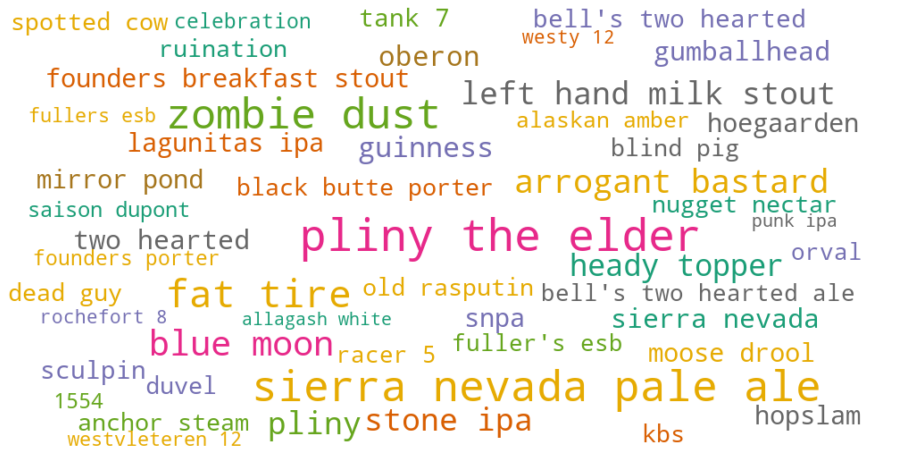

In [46]:
fig, ax = make_wordcloud(clones / clones.sum())

In [87]:
fig.savefig(os.path.join(DOCS_IMAGES_DIR, "clones_wordcloud.png"))

# Most Popular Ferms/Hops/Yeasts

In [47]:
with pd.HDFStore(recipes_h5) as store:
    ing = store.select(key="/ingredients", columns=["ferm_name", "hop_name", "yeast_name"])

In [48]:
ing.head()

,ferm_name,hop_name,yeast_name
id,,,
0,bohemian pilsner,motueka,safale s-04
0,vienna,motueka,NaN
0,white wheat,motueka,NaN
0,carared,NaN,NaN
1,white wheat,magnum,american wheat


In [49]:
map_pickles = os.path.join(DATA_DIR, "interim/{}map.pickle")
with open(map_pickles.format("ferm"),"rb") as f:
    fermmap = pickle.load(f)
with open(map_pickles.format("yeast"),"rb") as f:
    yeastmap = pickle.load(f)
with open(map_pickles.format("hop"),"rb") as f:
    hopmap = pickle.load(f)    

In [50]:
ing["ferm_name_map"] = ing.ferm_name.map(fermmap)
ing["yeast_name_map"] = ing.yeast_name.map(yeastmap)
ing["hop_name_map"] = ing.hop_name.map(hopmap)

In [51]:
ferms = ing.groupby(ing.index).ferm_name_map.unique().explode().value_counts(normalize=True)

In [52]:
with pd.option_context('display.max_rows', None):
    pprint(ferms[:50])

2-row                           0.111714
pilsen malt                     0.046787
carapils® malt                  0.043256
white wheat                     0.040840
caramel/crystal 60l             0.040172
maris otter pale                0.034011
caramel malt 40l                0.031463
roasted barley                  0.026549
flaked oats                     0.026139
dry malt extract - light        0.024682
vienna                          0.024386
chocolate malt                  0.021070
liquid malt extract - light     0.021044
munich malt                     0.020707
chocolate                       0.020691
caramel malt 20l                0.019253
caramel malt 120l               0.018641
caramel malt 80l                0.017005
black malt                      0.016251
flaked wheat                    0.015005
munich malt 10l                 0.014837
victory® malt                   0.014078
special b                       0.013721
caramel malt 10l                0.013077
corn sugar (dext

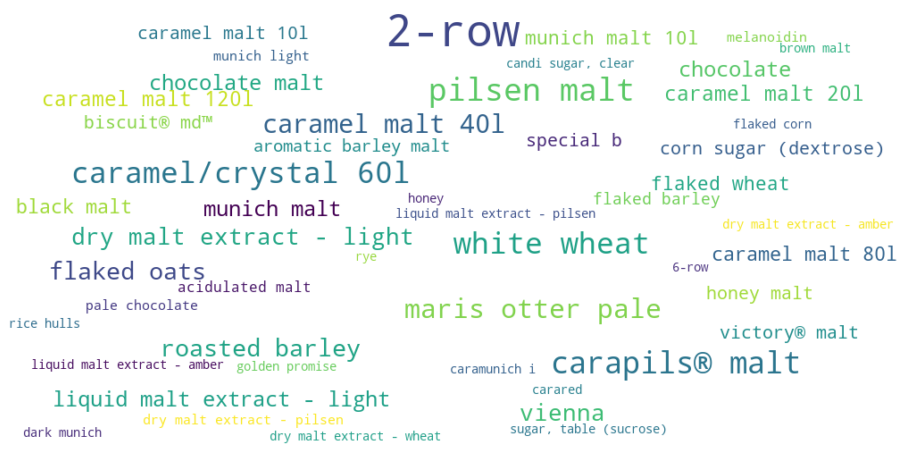

In [86]:
# XXX - update cmap for ferms to be brown
fig_ferm, ax_ferm = make_wordcloud(ferms, prefer_horizontal=True)

In [61]:
fig_ferm.savefig(os.path.join(DOCS_IMAGES_DIR, "fermentable_wordcloud.png"))

In [54]:
hops = ing.groupby(ing.index).hop_name_map.unique().explode().value_counts(normalize=True)
with pd.option_context('display.max_rows', None):
    pprint(hops[:50])

cascade                   0.106182
centennial                0.059404
east kent golding         0.057795
citra                     0.050860
amarillo                  0.049242
columbus                  0.044198
simcoe                    0.041241
chinook                   0.040338
saaz                      0.039645
willamette                0.039424
magnum                    0.038928
fuggle                    0.038084
hallertau                 0.037235
northern brewer           0.027701
tettnanger                0.020584
warrior                   0.019411
nugget                    0.019008
mosaic™                   0.016243
perle                     0.015708
styrian golding           0.015059
galaxy                    0.011814
mount hood                0.010987
nelson sauvin             0.009495
summit                    0.009156
hallertauer mittelfrüh    0.008781
challenger                0.008655
galena                    0.007863
cluster                   0.007784
hersbrucker         

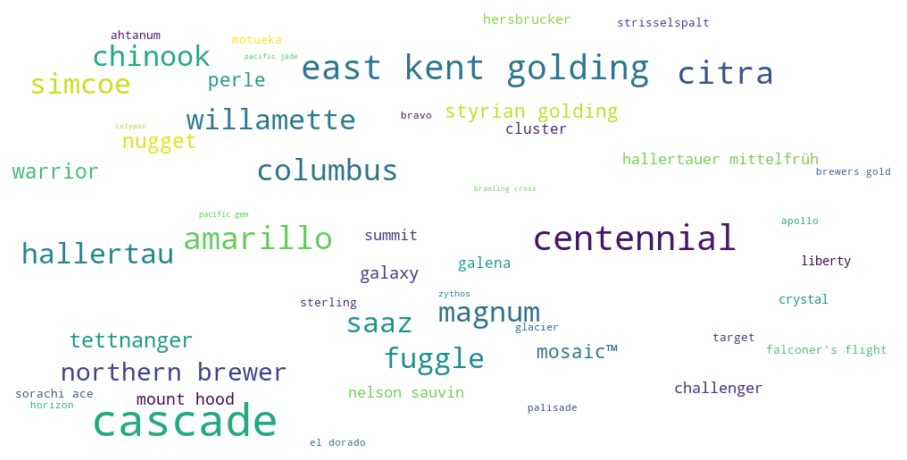

In [83]:
# XXX - update cmap for hops to be green
fig_hops, ax_hops = make_wordcloud(hops, prefer_horizontal=1)

In [62]:
fig_hops.savefig(os.path.join(DOCS_IMAGES_DIR, "hops_wordcloud.png"))

In [58]:
yeasts = ing.groupby(ing.index).yeast_name_map.unique().explode().value_counts(normalize=True)
with pd.option_context('display.max_rows', None):
    pprint(yeasts[:50])

safale us-05                       0.217673
american ale                       0.094032
american ale ii                    0.084339
safale s-04                        0.079148
french saison                      0.025749
london ale iii                     0.024168
london esb ale                     0.021747
california lager                   0.018952
scottish ale                       0.017636
irish ale                          0.016812
weihenstephan weizen               0.016553
california ale                     0.015996
belgian abbey ii                   0.013855
belgian ale                        0.013558
belgian wit ale                    0.013414
fermentis us-05                    0.012794
german ale                         0.012454
british ale                        0.011944
safbrew t-58                       0.011902
london ale                         0.011192
denny's favorite 50                0.010738
saflager w-34/70                   0.010564
trappist high gravity           

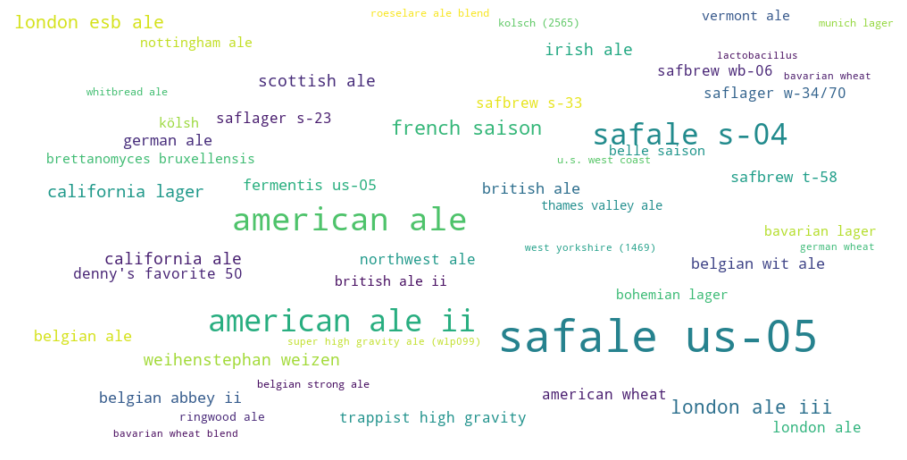

In [81]:
# update cmap for yeasts to be.... purple?
fig_yeast, ax_yeast = make_wordcloud(yeasts,
                                     #color_func=lambda *args, **kwargs: "purple",
                                     #colormap="Purples",
                                     prefer_horizontal=1
                      )

In [82]:
fig_yeast.savefig(os.path.join(DOCS_IMAGES_DIR, "yeast_wordcloud.png"))

# Batch Sizes

In [50]:
core.head()

,batch_size,boil_size,boil_time,brewer,efficiency,name,origin,recipe_file,src_abv,src_color,src_fg,src_ibu,src_og,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,,,,,,,
0,18.927059,21.198306,60.0,velkyal,0.75,dark island oir leann,brewtoad,recipes/brewtoad/dark-island-oir-leann.xml,NaN,NaN,NaN,NaN,NaN,6b,bjcp,blonde ale,1.0
1,22.712471,28.390588,60.0,wain thor,0.85,witbur,brewtoad,recipes/brewtoad/witbur.xml,NaN,NaN,NaN,NaN,NaN,6d,bjcp,american wheat or rye beer,1.0
2,20.819765,24.983718,60.0,btfielder,0.75,kolsch,brewtoad,recipes/brewtoad/kolsch-9285a4.xml,NaN,NaN,NaN,NaN,NaN,6c,bjcp,kölsch,1.0
3,18.927059,23.658824,60.0,viff brewing,0.75,amber alert,brewtoad,recipes/brewtoad/amber-alert-4.xml,NaN,NaN,NaN,NaN,NaN,10b,bjcp,american amber ale,1.0
4,18.927059,23.658824,60.0,pistolpete2,0.75,graff,brewtoad,recipes/brewtoad/graff-14.xml,NaN,NaN,NaN,NaN,NaN,20a,bjcp,fruit beer,1.0


In [51]:
core.batch_size.value_counts()[:50]

18.927059    124324
20.819765     70711
22.712471     23553
37.854118      9929
20.000000      9479
11.356235      7802
20.781911      7781
41.639530      7499
3.785412       6423
23.000000      5503
19.873412      4976
25.000000      4961
9.463529       4789
21.000000      4551
24.605177      3813
45.424941      3349
15.141647      2810
22.000000      2597
7.570824       2581
37.891972      2382
19.000000      2218
10.000000      2125
13.248941      2077
19.684141      1781
26.497882      1684
17.034353      1658
18.930000      1614
50.000000      1572
Name: batch_size, dtype: int64

In [52]:
import seaborn as sns

<AxesSubplot:>

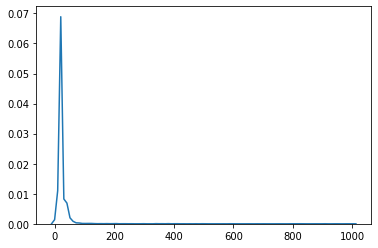

In [53]:
sns.kdeplot(core[core.batch_size < 1000].batch_size.values)